# Introduction to `laplax` for regression tasks

This tutorial follows the `laplace-torch` regression tutorial and provides a quick overview of the different functionalities which are currently supported by `laplax`.

For the dataset we consider sinus as our target with additional observation noise $\sigma^2 = 0.3$. To make the task harder, we only consider training and validation data on a few subintervals.

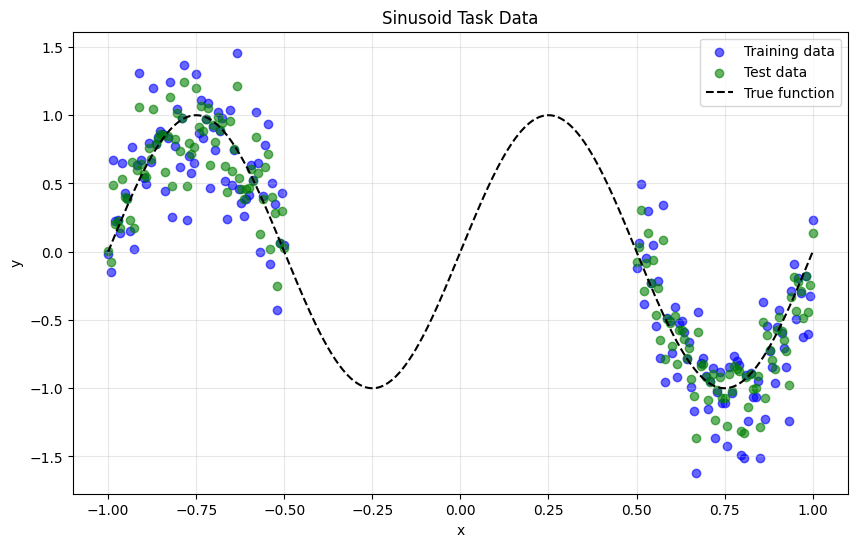

In [130]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from helper import DataLoader, get_sinusoid_example
from plotting import plot_sinusoid_task
import laplax
from laplax.extra.fsp import lanczos_isqrt
from ex_regression import save_model_checkpoint, load_model_checkpoint
jax.config.update("jax_enable_x64", True)

n_epochs = 1000
key = jax.random.key(0)

# Sample toy data example
num_training_samples = 150
num_calibration_samples = 50
num_test_samples = 150

batch_size = 10
X_train, y_train, X_valid, y_valid, X_test, y_test = get_sinusoid_example(
    num_train_data=num_training_samples,
    num_valid_data=num_calibration_samples,
    num_test_data=num_test_samples,
    sigma_noise=0.01,
    intervals=[(0, 3.14), (6.28, 10)],
    rng_key=jax.random.key(0)
)
X_train1 = jnp.linspace(-1, -0.5, 75).reshape(-1, 1)
X_train2 = jnp.linspace(0.5, 1, 75).reshape(-1, 1)
X_train = jnp.concatenate([X_train1, X_train2], axis=0)
y_train = jnp.reshape(jnp.sin(X_train * 6.24) + jax.random.normal(key, (150, 1)) * 0.3, (-1, 1))
X_test = X_train
y_test = jnp.reshape(jnp.sin(X_train * 6.24) + jax.random.normal(key, (150, 1)) * 0.2, (-1, 1))
train_loader = DataLoader(X_train, y_train, batch_size)

fig = plot_sinusoid_task(X_train, y_train, X_test, y_test)
key = jax.random.PRNGKey(113756440)

## Training for the MAP

In this tutorial, we use `flax.nnx` for setting up neural networks in `jax`, but other libraries (e.g., `equinox` or `flax.linen`) should also work out of the box since we will only require a split into `model_fn` and `params` for `laplax`, which all of them provide.

From a Bayesian perspective supervised learning can be seen as finding the maximum-a-posteriori estimate of the joint log likelihood:

$$ \text{arg}\max_{\theta_\in\mathbb{R}^{P}} = \sum_{n=1}^{N} \log p(y_n \vert f(x_n, \theta) )+ \log p(\theta) $$

where:
- $f$ is the neural network,
- $\theta \in \mathbb{R}^{P}$ its parameters, and
- $\mathcal{D} := \{(x_n, y_n)\}_{n=1}^{N}$ the labelled dataset.

In [93]:
def select_context_points(
    n_context_points: int,
    context_selection: str = "grid",
    context_points_maxval: list[float] = [2.0],
    context_points_minval: list[float] = [-2.0],
    datapoint_shape: tuple[int, ...] = X_train.shape,
    key: jax.random.PRNGKey = key,
    scale: float = 1.0,
):
    D = datapoint_shape[-1]

    scaled_max = jnp.array(context_points_maxval) * scale
    scaled_min = jnp.array(context_points_minval) * scale

    if context_selection == "random":
        window_len = (scaled_max - scaled_min) / 4.0

        start = jax.random.uniform(
            key,
            shape=(D,),
            minval=scaled_min,
            maxval=scaled_max - window_len,
        )

        w_min = start
        w_max = start + window_len

        context_points = jax.random.uniform(
            key,
            shape=(n_context_points, D),
            minval=w_min,
            maxval=w_max,
        )

    elif context_selection == "grid":
        if D == 1:
            context_points = jnp.linspace(
                context_points_minval[0], context_points_maxval[0], n_context_points
            ).reshape(-1, 1)
        else:
            raise NotImplementedError("Grid for D>1")

    else:
        raise ValueError(f"Unknown context_selection={context_selection!r}")

    return context_points


In [115]:
def periodic_kernel(x, y, lengthscale, period, variance=1.0):
    """x, y: arrays of shape [..., D]
    returns: variance * exp[-2 * sum(sin^2(pi*(x-y)/period)) / lengthscale^2]
    """
    # compute pairwise sin^2 term
    arg = jnp.pi * (x - y) / period
    sin2 = jnp.sin(arg)**2                          # [..., D]
    return variance * jnp.exp(-2.0 * jnp.sum(sin2, axis=-1) / lengthscale**2)

def matern52_kernel(x, y, lengthscale, variance=1.0):
    """k(r) = variance * (1 + sqrt(5)r/ℓ + 5r^2/(3ℓ^2)) * exp(-sqrt(5)r/ℓ)
    where r = ||x-y||_2
    """
    r = jnp.linalg.norm(x - y, axis=-1)
    sqrt5 = jnp.sqrt(5.0)
    sr = sqrt5 * r / lengthscale
    return variance * (1.0 + sr + sr**2/3.0) * jnp.exp(-sr)

def matern12_kernel(x, y, lengthscale, variance=1.0):
    """
    Exponential kernel: k(r) = variance * exp(-r/ℓ)
    """
    r = jnp.linalg.norm(x - y, axis=-1)
    return variance * jnp.exp(-r / lengthscale)

def composite_kernel(x, y, params):
    """params: {
      "per_ls": float,
      "per_p":   float,
      "per_var": float,
      "m52_ls":  float,
      "m52_var": float,
      "m12_ls":  float,
      "m12_var": float,
    }
    x: [N, D], y: [M, D] → returns [N, M].
    """  # noqa: D205
    # broadcast to [N, M, D]
    X = x[:, None, :]
    Y = y[None, :, :]

    k_per  = periodic_kernel(  X, Y,
                              params["per_ls"],
                              params["per_p"],
                              params.get("per_var", 1.0))
    k_m52  = matern52_kernel(  X, Y,
                              params["m52_ls"],
                              params.get("m52_var", 1.0))
    k_m12  = matern12_kernel(  X, Y,
                              params["m12_ls"],
                              params.get("m12_var", 1.0))

    #return k_per# + k_m12# * k_m52 #+ k_m12
    return k_per * k_per * k_m52 + k_m12


params = {
    "per_ls": 280, "per_p": 1.0, "per_var": 1.0,
    "m52_ls": 1.0, "m52_var": 1.0,
    "m12_ls": 0.25, "m12_var": 0.0002,
}

#params = {
#     "per_ls": 280, "per_p": 1.0, "per_var": 1.0,
#     "m52_ls": 1.0, "m52_var": 1.0,
#     "m12_ls": 0.25, "m12_var": 0.0002,
# }

def gram(x: jnp.ndarray,
         params: dict = params,
         kernel_fn = composite_kernel,
         jitter: float = 1e-6) -> jnp.ndarray:
    K = kernel_fn(x, x, params)               # [N, N]
    return K + jitter * jnp.eye(x.shape[0])

# X: [N, D]
K = gram(jnp.linspace(-3, 3, 15).reshape(-1,1), params, composite_kernel, jitter=1e-16)
assert jnp.linalg.eigvalsh(K).all() > 0, "Gram matrix is not positive definite"

In [116]:
def create_nll(model, x, y, scale=0.01):
    """
    Compute the negative log-likelihood loss.
    
    Args:
        model: The neural network model
        x: Input data
        y: Target data
        scale: Standard deviation for the Gaussian likelihood
    
    Returns:
        Negative log-likelihood loss
    """
    y_pred = model(x)
    nll = -jax.scipy.stats.norm.logpdf(
        y,
        loc=y_pred,
        scale=scale
    ).mean()
    return nll

def create_regularize(model, x_context, prior_cov):
    """
    Compute the RKHS regularization term.
    
    Args:
        model: The neural network model
        x_context: Context points for regularization
        prior_cov: Prior covariance matrix (Gram matrix)
    
    Returns:
        RKHS regularization term
    """
    f_c = model(x_context)
    f_c = f_c.reshape(-1)
    rkhs = (f_c.T @ jnp.linalg.solve(prior_cov, f_c)).reshape(-1).squeeze(-1)
    return rkhs

def create_fsp_objective(model, x, y, key, 
                        nll_weight=150, 
                        reg_weight=0.5, 
                        scale=0.001,
                        n_context_points=150,
                        context_selection="grid"):
    """
    Compute the full FSP objective: regularization + weighted NLL.
    
    Args:
        model: The neural network model
        x: Input data
        y: Target data
        key: JAX random key for context point selection
        nll_weight: Weight for the NLL term
        reg_weight: Weight for the regularization term
        scale: Standard deviation for the Gaussian likelihood
        n_context_points: Number of context points to select
        context_selection: Method for selecting context points
    
    Returns:
        Combined FSP objective loss
    """
    # Compute NLL
    nll = create_nll(model, x, y, scale)
    
    # Select context points and compute prior covariance
    x_context = select_context_points(
        n_context_points=n_context_points, 
        context_selection=context_selection, 
        key=key
    )
    prior_cov = gram(x_context)
    
    # Compute regularization
    reg = create_regularize(model, x_context, prior_cov)
    
    # Combine terms
    total_loss = reg_weight * reg + nll_weight * nll
    return total_loss

In [129]:
from typing import Callable, Dict, Any
ModelFn = Callable
LossFn = Callable  
Data = Dict[str, Any]
Params = Any
PredArray = jnp.ndarray
Float = float



def create_loss_nll(
    model_fn: ModelFn,
    loss_fn: LossFn,
):
    r"""Create the NLL loss function for FSP training.
    
    Computes the negative log-likelihood:
    $$
    -\log p(y | f(X)) = -\sum_i \log \mathcal{N}(y_i | f(x_i), \sigma^2)
    $$
    """
    def loss_nll(
        data: Data, params: Params, other_params: Params | None = None
    ) -> Float:
        preds = jax.vmap(model_fn, in_axes=(0, None))(data["input"], params)
        return loss_fn(preds, data["target"], other_params)
    
    return loss_nll

def create_loss_reg(
    model_fn: ModelFn,
    prior_mean: PredArray,
    prior_cov_kernel: Callable[[PredArray, PredArray], Float],
):
    r"""Create the FSP regularization loss function.
    
    Computes the RKHS regularization:
    $$
    \frac{1}{2} (f(c) - m)^T K^{-1}(c, c) (f(c) - m)
    $$
    """
    def loss_reg(context_points: PredArray, params: Params) -> Float:
        f_c = jax.vmap(model_fn, in_axes=(0, None))(context_points, params) - prior_mean
        K_c_c = prior_cov_kernel(context_points, context_points)
        left = jax.numpy.linalg.solve(K_c_c, f_c)
        return 0.5 * jax.numpy.einsum("ij,ij->", f_c, left)
    
    return loss_reg

def create_fsp_objective(
    model_fn: ModelFn,
    loss_fn: LossFn,
    prior_mean: PredArray,
    prior_cov_kernel: Callable,
    reg_weight: float = 1.0,
):
    """Create FSP objective combining NLL and regularization losses."""
    # Create loss functions
    loss_nll = create_loss_nll(model_fn, loss_fn)
    loss_reg = create_loss_reg(model_fn, prior_mean, prior_cov_kernel)
    
    def fsp_objective(
        data: Data, 
        context_points: PredArray, 
        params: Params, 
        other_params: Params | None = None
    ) -> Float:
        nll_term = loss_nll(data, params, other_params)
        reg_term = loss_reg(context_points, params)
        return nll_term + reg_weight * reg_term
    
    return fsp_objective


@nnx.jit
def train_step_functional(
    fsp_objective: Callable,
    optimizer: nnx.Optimizer,
    data: Data,
    context_points: PredArray,
    params: Params,
    other_params: Params | None = None,
):
    """Training step using functional FSP objective."""
    def loss_fn(params):
        return fsp_objective(data, context_points, params, other_params)
    
    loss, grads = nnx.value_and_grad(loss_fn)(params)
    optimizer.update(grads)
    return loss

def train_model_functional(
    model_fn: ModelFn,
    loss_fn: LossFn,
    prior_mean: PredArray,
    prior_cov_kernel: Callable,
    train_loader,
    n_epochs: int,
    lr: float = 1e-3,
    reg_weight: float = 1.0,
    context_points_fn: Callable = None,
    key: jax.random.PRNGKey = None,
):
    """Training loop using functional FSP objective."""
    if key is None:
        key = jax.random.PRNGKey(42)
    
    # Create FSP objective
    fsp_objective = create_fsp_objective(
        model_fn, loss_fn, prior_mean, prior_cov_kernel, reg_weight
    )
    
    # Initialize parameters (this depends on your model initialization)
    # params = initialize_params(model_fn, key)  # You'll need to implement this
    
    # Create optimizer
    # optimizer = nnx.Optimizer(params, optax.adam(lr))  # Adjust based on your setup
    
    for epoch in range(n_epochs):
        epoch_key = jax.random.fold_in(key, epoch)
        
        for batch_idx, batch_data in enumerate(train_loader):
            batch_key = jax.random.fold_in(epoch_key, batch_idx)
            
            # Convert batch to expected format
            data = {
                "input": batch_data[0],
                "target": batch_data[1]
            }
            
            # Get context points for this batch
            if context_points_fn is not None:
                context_points = context_points_fn(batch_key)
            else:
                # Default context point selection - you'll need to implement this
                context_points = select_context_points()
                
            
            # Training step
            loss = train_step_functional(
                fsp_objective, optimizer, data, context_points, params
            )
        
        if epoch % 100 == 0:
            print(f"[epoch {epoch}]: loss: {loss:.4f}")
    return params, optimizer

In [ ]:
def prior_gram_matrix(ker, x, ll_scale=0.1):
    K = gram(x, params, composite_kernel, jitter=1e-6)
    return K 



# Create and train MAP model
class Model(nnx.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, rngs):
        self.linear1 = nnx.Linear(in_channels, hidden_channels, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_channels, hidden_channels, rngs=rngs)
        self.linear3 = nnx.Linear(hidden_channels, out_channels, rngs=rngs)

    def __call__(self, x):
        x = self.linear3(
            nnx.tanh(self.linear2(
                nnx.tanh(self.linear1(x)))
                )
            )
        return x
    
fsp_objective = create_fsp_objective(
        model_fn, loss_fn, prior_mean, prior_cov_kernel, reg_weight
    )


@nnx.jit
def train_step(model, optimizer, x, y):
    # def loss_fn(model):
    #     y_pred = model(x)
    #     x_context = select_context_points(n_context_points=150, context_selection="grid", key=key)
    #     prior_cov = gram(x_context)
    #     f_c = model(x_context)
    #     f_c = f_c.reshape(-1)
    #     rkhs = (f_c.T @ jnp.linalg.solve(prior_cov, f_c)).reshape(-1).squeeze(-1)
    #     #rkhs = f_c.T @ jnp.linalg.inv(prior_cov) @ f_c
    #     nll = -jax.scipy.stats.norm.logpdf(
    #         y, 
    #         loc=y_pred, 
    #         scale=0.01, # 0.001
    #     ).mean() 
    #     return 0.5 * rkhs + nll * 150
    def loss_fn(params):
        return fsp_objective(data, context_points, params, other_params)
    

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # Inplace updates

    return loss


def train_model(model, n_epochs, lr=1e-3):
    # Create optimizer
    optimizer = nnx.Optimizer(model, optax.adam(lr))  # Reference sharing

    # Train epoch
    for epoch in range(n_epochs):
        for x_tr, y_tr in train_loader:
            loss = train_step(model, optimizer, x_tr, y_tr)

        if epoch % 100 == 0:
            print(f"[epoch {epoch}]: loss: {loss:.4f}")

    print(f"Final loss: {loss:.4f}")
    return model



[epoch 0]: loss: 10010517.4447
[epoch 100]: loss: 8030615.7919
[epoch 200]: loss: 16990015.4240
[epoch 300]: loss: 10216523.5040
[epoch 400]: loss: 7986686.7929
[epoch 500]: loss: 3980809.2389
[epoch 600]: loss: 5410925.8842
[epoch 700]: loss: 1835873.1744
[epoch 800]: loss: 10903953.7470
[epoch 900]: loss: 7432191.4415
[epoch 1000]: loss: 6030764.2857
[epoch 1100]: loss: 4804586.6174
[epoch 1200]: loss: 3913832.8729
[epoch 1300]: loss: 5262996.8698
[epoch 1400]: loss: 5804867.7772
[epoch 1500]: loss: 9228110.2717
[epoch 1600]: loss: 8100820.8130
[epoch 1700]: loss: 5042581.6217
[epoch 1800]: loss: 8899109.9122
[epoch 1900]: loss: 13827339.5052


2025-05-25 22:10:31.481 | INFO     | ex_regression:save_model_checkpoint:35 - Model checkpoint saved to models


Final loss: 3480191.8945


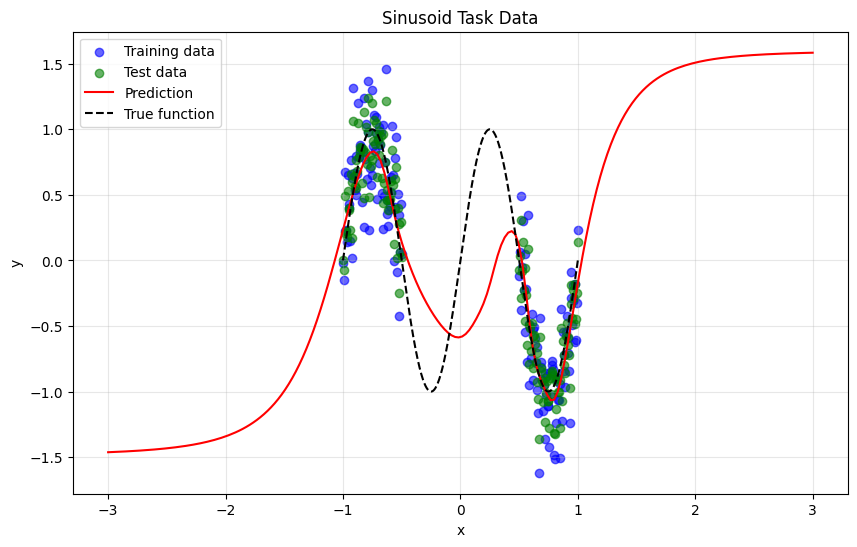

In [118]:
from helper import to_float64
model = Model(in_channels=1, hidden_channels=50, out_channels=1, rngs=nnx.Rngs(2))
model = to_float64(model)
model_kwargs = {
    "in_channels": 1,
    "hidden_channels": 64,
    "out_channels": 1,
}
# load model checkpoint if available
# model, graph_def, params = load_model_checkpoint(Model, model_kwargs, 'models/')
# Train model
model = train_model(model, n_epochs=2000)
save_model_checkpoint(model, 'models/')

X_pred = jnp.linspace(-3., 3., 200).reshape(200, 1)
y_pred = jax.vmap(model)(X_pred)

_ = plot_sinusoid_task(X_train, y_train, X_test, y_test, X_pred, y_pred)

In [119]:
def lanczos_isqrt(
    A,
    b,
    *,
    tol=1e-5,  # 1e-5
    min_eta=1e-20,
    max_iter=500,
    overwrite_b=False,
):
    """Conjugate gradient method to solve the linear system Ax = b.

    params:
    - A (callable): linear operator.
    - b (array): right-hand side.
    - x0 (array): initial guess.
    - atol (float): absolut tolerance.
    - tol (float): relative tolerance.
    - max_iter (int): maximum number of iterations.
    """

    @jax.jit
    def _step(values):
        ds, rs, rs_norm_sq, p, eta, k = values
        # Compute search direction
        true_fn = lambda _p: rs[:, k] + rs_norm_sq[k] / rs_norm_sq[k - 1] * _p
        false_fn = lambda _p: _p
        p = jax.lax.cond(k > 0, true_fn, false_fn, p)

        # Compute modified Lanzcos vector
        w = A @ p  # A(p) or A @ p
        eta = p @ w
        ds = ds.at[:, k].set(p / jnp.sqrt(eta))

        # Update residual
        mu = rs_norm_sq[k] / eta
        rs_prev_k = rs  # rs[:, :k]
        rs = rs.at[:, k + 1].set(rs[:, k] - mu * w)

        # Full reorthogonalization of residual (double Gram-Schmidt)
        rs = rs.at[:, k + 1].set(
            rs[:, k + 1] - rs_prev_k @ ((rs_prev_k.T @ rs[:, k + 1]) / rs_norm_sq)
        )
        rs = rs.at[:, k + 1].set(
            rs[:, k + 1] - rs_prev_k @ ((rs_prev_k.T @ rs[:, k + 1]) / rs_norm_sq)
        )

        rs_norm_sq = rs_norm_sq.at[k + 1].set(rs[:, k + 1].T @ rs[:, k + 1])
        jax.debug.print("eta: {a} - sq_norm = {r}", a=eta, r=rs_norm_sq[k])

        return ds, rs, rs_norm_sq, p, eta, k + 1

    def _cond_fun(values):
        ds, rs, rs_norm_sq, p, eta, k = values
        return (rs_norm_sq[k] > tol**2) & (k < max_iter) & (eta > min_eta)

    # Initialization
    b /= jnp.linalg.norm(b, 2)
    ds = jnp.zeros((b.size, max_iter))  # only implemented for order='K'
    rs = jnp.zeros((b.size, max_iter + 1))  #   only implemented for order='K'
    rs_norm_sq = jnp.ones_like(rs, shape=max_iter + 1)

    # Initialize loop variables
    # tol = jnp.finfo(A.dtype).eps
    sqtol = (
        tol**2
    )  # max(tol ** 2, jnp.finfo(A.dtype).eps) if tol is not None else jnp.finfo(A.dtype).eps
    # min_eta = min_eta  # max(min_eta, jnp.finfo(A.dtype).eps) if min_eta is not None else jnp.finfo(A.dtype).eps
    eta = jnp.inf  # to make sure the first iteration is done
    rs = rs.at[:, 0].set(b)
    p = b if overwrite_b else b.copy()

    # Lanczos iterations
    ds, _, _, _, _, k = jax.lax.while_loop(
        _cond_fun, _step, (ds, rs, rs_norm_sq, p, eta, 0)
    )

    return ds[:, :k]



def lanczos_jacobian_initialization(
    model_fn,
    params,
    data,
    *,
    lanczos_initialization_batch_size: int = 20,
):
    # Define model Jacobian vector product
    initial_vec = jax.jvp(
        lambda w: model_fn(data["input"], params=w),
        (params,),
        (laplax.util.tree.ones_like(params),),
    )[1]
    initial_vec = initial_vec / jnp.linalg.norm(initial_vec, 2)

    return initial_vec.squeeze(-1)


In [120]:
def compute_matrix_jacobian_product(
    model_fn,
    params,
    data,
    matrix,
):
    flatten, unflatten = laplax.util.flatten.create_partial_pytree_flattener(params)

    M_tree = jax.vmap(
        jax.vjp(
            lambda p: jnp.reshape(
                model_fn(data["input"], params=p), (matrix.shape[0],)
            ),
            params,
        )[1],
        in_axes=0,  # 0
        out_axes=0,  # 0
    )(matrix)

    M, unravel_fn = jax.flatten_util.ravel_pytree(
        M_tree,
    )
    return M, unravel_fn

In [121]:
data = {
    "input": X_train,
    "target": y_train,
}

graph_def, params = nnx.split(model)

def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


v = lanczos_jacobian_initialization(model_fn, params, data)

context_points = select_context_points(150, "grid",
        [2.0],
        [-2.0],
        X_train.shape,
    )
cov_matrix = gram(context_points)
prior_var = jnp.diag(cov_matrix)

In [122]:
import jax.flatten_util
import jax.numpy as jnp
from laplax.util.flatten import create_partial_pytree_flattener

data = {
    "input": X_train,
    "target": y_train,
}

graph_def, params = nnx.split(model)

def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


v = lanczos_jacobian_initialization(model_fn, params, data)
context_points = select_context_points(150, "grid",
        [2],
        [-2],
        data["input"].shape[1:],
    )
cov_matrix = gram(context_points)

L = lanczos_isqrt(cov_matrix, v, tol=jnp.finfo(v.dtype).eps)

vjp_jit = jax.jit(lambda _x, _k_c: jax.vmap(jax.vjp(lambda _p: model_fn(_p, _x)[:], params)[1], in_axes=1, out_axes=1)(_k_c)[0])
zeros_pytree = jax.tree.map(lambda x: x*0, params)
M_tree = jax.vmap(
        jax.vjp(
            lambda p: jnp.reshape(
                model_fn(data["input"], params=p), (L.shape[0],)
            ),
            params,
        )[1],
        in_axes=1,  # 0
        out_axes=1,  # 0
    )(L)
M, unravel_fn = jax.flatten_util.ravel_pytree(
        M_tree,
    )
M = M.reshape((-1, L.shape[-1]))
flatten, unflatten = create_partial_pytree_flattener(params)


data = {
    "input": X_train,
    "target": y_train,
}

graph_def, params = nnx.split(model)

def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


v = lanczos_jacobian_initialization(model_fn, params, data)
context_points = select_context_points(150, "grid",
        [3],
        [-3],
        data["input"].shape[1:],
    )
cov_matrix = gram(context_points)
L = lanczos_isqrt(cov_matrix, v)

vjp_jit = jax.jit(lambda _x, _k_c: jax.vmap(jax.vjp(lambda _p: model_fn(_p, _x)[:], params)[1], in_axes=1, out_axes=1)(_k_c)[0])
zeros_pytree = jax.tree.map(lambda x: x*0, params)
M_tree = jax.vmap(
        jax.vjp(
            lambda p: jnp.reshape(
                model_fn(data["input"], params=p), (L.shape[0],)
            ),
            params,
        )[1],
        in_axes=1,  # 0
        out_axes=1,  # 0
    )(L)
M, unravel_fn = jax.flatten_util.ravel_pytree(
        M_tree,
    )
M = M.reshape((-1, L.shape[-1]))

from laplax.util.flatten import create_partial_pytree_flattener
flatten, unflatten = create_partial_pytree_flattener(params)
#unravel_fn = jax.flatten_util.ravel_pytree(M[:, 0])[1]
#unflatten(M)
M.shape

eta: 35.40227486362753 - sq_norm = 1.0
eta: 1.6731686979236537 - sq_norm = 0.1682442351318215
eta: 11.68702075951146 - sq_norm = 0.3384417173588845
eta: 1.1450764989768978 - sq_norm = 0.19021265234200396
eta: 0.47917838517178324 - sq_norm = 0.3474744651375197
eta: 0.14004828994288349 - sq_norm = 0.21658514455446293
eta: 0.46095214883114266 - sq_norm = 0.27875829070381
eta: 0.07406349962419775 - sq_norm = 0.16340214929547794
eta: 0.013279901680758344 - sq_norm = 0.09864969998403106
eta: 0.010019202731235351 - sq_norm = 0.12125997309405374
eta: 0.006580695486695297 - sq_norm = 0.11428888653838612
eta: 0.0011113849030674678 - sq_norm = 0.10113192544546032
eta: 0.0004977911168528108 - sq_norm = 0.07243572783658393
eta: 0.0034639399017711587 - sq_norm = 0.13579838511354644
eta: 0.0004405140954788683 - sq_norm = 0.07553348128937183
eta: 0.0005966960198070593 - sq_norm = 0.09482026016578257
eta: 0.00010315279295735474 - sq_norm = 0.05140163798227553
eta: 6.054507386683197e-05 - sq_norm = 0.03

(2701, 51)

In [123]:
data = zip(data["input"], data["target"])

In [124]:
def ggn_matmul(
    model_fn,    # fn: (x_batch, params) -> preds
    loss_fn,     # fn: (preds, y_batch) -> scalar loss
    params,      # pytree of parameters
    dataloader,  # iterable of (x_batch, y_batch)
    unravel_fn,  # fn: flat_vector -> pytree matching `params`
    M_flat       # array of shape (num_params, num_vectors)
):
    # unpack each vector in M into a pytree
    Ms = [unravel_fn(v) for v in M_flat.T]

    # initialize Fisher–GGN accumulators to zero pytrees
    zeros = lambda: jax.tree.map(jnp.zeros_like, params)
    precs = [zeros() for _ in Ms]

    # accumulate over batches
    for x_b, y_b in dataloader:
        for i, v in enumerate(Ms):
            ggv = _ggn_vector_product(model_fn, loss_fn, params, x_b, y_b, v)
            # elementwise add into the i-th accumulator
            precs[i] = jax.tree.map(lambda a, b: a + b, precs[i], ggv)

    # flatten each pytree result back to a vector and stack as columns
    flat_cols = [jax.flatten_util.ravel_pytree(p)[0] for p in precs]
    return jnp.stack(flat_cols, axis=-1)


def _ggn_vector_product(
    model_fn,  # (x_batch, params) -> preds
    loss_fn,   # (preds, y_batch) -> scalar loss
    params,    # current pytree
    x_b, y_b,  # one minibatch
    v          # pytree with same structure as params
):
    # 1) define f: params -> preds
    f = lambda p: model_fn(x_b, p)

    # 2) forward-propagate your vector:
    preds_at_p, jvp_out = jax.jvp(f, (params,), (v,))

    # 3) compute directional derivative of ∇_pred loss, i.e. Hessian–vector in prediction space:
    grad_loss_wrt_preds = jax.grad(lambda preds: loss_fn(preds, y_b))
    _, hvp_pred = jax.jvp(grad_loss_wrt_preds, (preds_at_p,), (jvp_out,))

    # 4) push that back to parameter-space with the transpose-Jacobian:
    _, vjp_fn = jax.vjp(f, params)
    return vjp_fn(hvp_pred)[0]

data = {
    "input": X_train,
    "target": y_train,
}
dataloader = [(data["input"], data["target"])]

loss_fn = lambda preds, y: jnp.mean(
    jax.scipy.stats.norm.logpdf(
        y,
        loc=preds,
        scale=0.1,
    )
)
# now call exactly as before
_u, _s, _ = jnp.linalg.svd(M, full_matrices=False)
eps = jnp.finfo(M.dtype).eps
tol = eps**0.5 #threshold for machine precision for torch.diag(s**2) + uT_ggn_u
s = _s[_s > tol]
u = _u[:, _s > tol]
flat_params, unravel_fn = jax.flatten_util.ravel_pytree(params)
ggn_linop = ggn_matmul(
    model_fn,
    loss_fn,
    params,
    dataloader,
    unravel_fn,
    u,
)


_u, _s, _ = jnp.linalg.svd(M, full_matrices=False)
eps = jnp.finfo(M.dtype).eps
tol = eps**0.5
s = _s[_s > tol]
u = _u[:, _s > tol]
print("u", u.shape, "s", s.shape)
ggn_linop.shape, u.shape

u (2701, 51) s (51,)


((2701, 51), (2701, 51))

In [125]:
uT_ggn_u = u.T @ ggn_linop
_eigvals, _eigvecs = jnp.linalg.eigh(jnp.diag(s**2) + uT_ggn_u)
tol = eps * (_eigvals.max()**0.5) * s.shape[0]
eigvals = _eigvals[_eigvals > tol] # for pseudo-inversion
eigvecs = _eigvecs[:, _eigvals > tol]
print("eigvals", eigvals.shape, "eigvecs", eigvecs.shape)
eigvals = jnp.flip(eigvals, axis=0)
eigvecs = jnp.flip(eigvecs, axis=1)

eigvals (50,) eigvecs (51, 50)


In [126]:
def normalize_eigvecs(evals, u, evecs):
    return u @ (evecs * (1 / jnp.sqrt(evals)))

def jvp(x, v):
    return jax.jvp(lambda p: model_fn(x, params=p), (params,), (v,))[1]

i = 0
post_var = jnp.zeros((prior_var.shape[0], 1))
prior_var_sum = jnp.sum(prior_var)
cov_sqrt = []
_, unflatten = laplax.util.flatten.create_pytree_flattener(params)
while jnp.all(post_var < prior_var) and i < eigvals.shape[0]:
    cov_sqrt += [jax.jit(normalize_eigvecs)(eigvals[i], u, eigvecs[:, i])]
    lr_fac_i = jax.jit(unflatten)(cov_sqrt[-1])
    context_points = select_context_points(150, "grid",
        [3],
        [-3],
        data["input"].shape[1:],
    )
    post_var += jnp.concatenate(
        [jax.jit(jvp)(x_c, lr_fac_i) ** 2 for x_c in context_points], axis=0
    )
    print(f"{i} - post_tr={post_var.sum()} - prior_tr={prior_var_sum}")
    i += 1

truncation_idx = i if i == eigvals.shape[0] else i - 1
print(f"Truncation index: {truncation_idx}")
cov_sqrt = jnp.stack(cov_sqrt[:truncation_idx], axis=-1)
cov_sqrt.min(), cov_sqrt.max(), cov_sqrt.mean(), cov_sqrt.std()


0 - post_tr=0.2127447192424277 - prior_tr=150.03015000000005
1 - post_tr=0.2147172613305131 - prior_tr=150.03015000000005
2 - post_tr=0.2218105826042631 - prior_tr=150.03015000000005
3 - post_tr=0.22812077899603955 - prior_tr=150.03015000000005
4 - post_tr=0.32734704388799657 - prior_tr=150.03015000000005
5 - post_tr=0.4641115497015456 - prior_tr=150.03015000000005
6 - post_tr=0.5657155068433277 - prior_tr=150.03015000000005
7 - post_tr=1.3179489622334783 - prior_tr=150.03015000000005
8 - post_tr=1.4190984963507898 - prior_tr=150.03015000000005
9 - post_tr=2.3640512441208505 - prior_tr=150.03015000000005
10 - post_tr=2.666472101877662 - prior_tr=150.03015000000005
11 - post_tr=3.179224978443542 - prior_tr=150.03015000000005
12 - post_tr=3.2799192618866027 - prior_tr=150.03015000000005
13 - post_tr=3.2879660821114136 - prior_tr=150.03015000000005
14 - post_tr=3.336867724353215 - prior_tr=150.03015000000005
15 - post_tr=3.471400305366981 - prior_tr=150.03015000000005
16 - post_tr=3.65203

(Array(-0.0293428, dtype=float64),
 Array(0.02997523, dtype=float64),
 Array(-3.46909645e-07, dtype=float64),
 Array(0.00087076, dtype=float64))

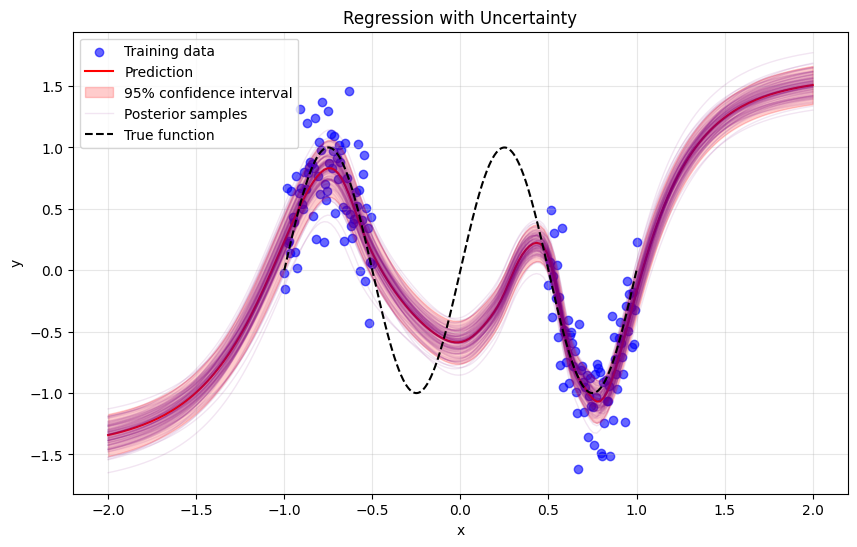

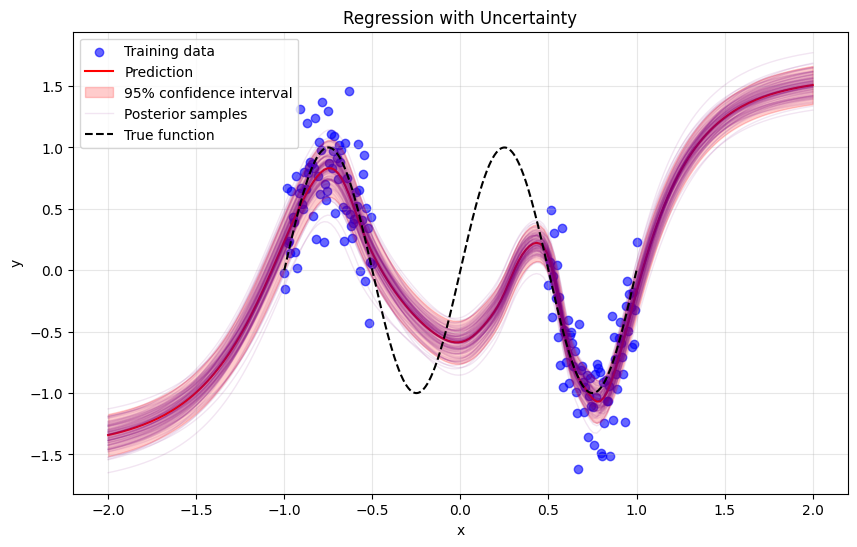

In [127]:
from functools import partial
from pathlib import Path
import pickle
from laplax.curv.cov import Posterior
from laplax.curv.cov import PosteriorState
from plotting import plot_regression_with_uncertainty
from laplax.eval.pushforward import set_lin_pushforward
from laplax.eval.pushforward import (
    lin_pred_mean,
    lin_pred_std,
    lin_pred_var,
    lin_samples,
    lin_setup,
    set_lin_pushforward,
)

posterior_state: PosteriorState = {"scale_sqrt": cov_sqrt}
flatten, unflatten = laplax.util.flatten.create_pytree_flattener(params)
posterior = Posterior(
    state=posterior_state,
    cov_mv=lambda state: lambda x: unflatten(
        state["scale_sqrt"] @ state["scale_sqrt"].T @ flatten(x)
    ),
    scale_mv=lambda state: lambda x: unflatten(state["scale_sqrt"] @ x),
    rank=cov_sqrt.shape[1],
)

posterior_fn = lambda *args, **kwargs: posterior  # noqa: E731

set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_var,
        lin_pred_std,
        lin_samples,
    ],
    key=jax.random.key(6548),
    num_samples=100,
)

prob_predictive = set_prob_predictive(
    prior_arguments={},
)
X_pred = jnp.linspace(-2, 2, 200, dtype=jnp.float64).reshape(-1, 1)

pred = jax.vmap(prob_predictive)(X_pred)
with Path("rbf.pkl").open("wb") as f:
        pickle.dump({"X_pred": X_pred, "pred": pred}, f)

X_pred = jnp.linspace(-2, 2, 200, dtype=jnp.float64).reshape(-1, 1)

pred = jax.vmap(prob_predictive)(X_pred)
plot_regression_with_uncertainty(
        X_train=data["input"],
        y_train=data["target"],
        X_pred=X_pred,
        y_pred=pred["pred_mean"][:, 0],
        y_std=jnp.sqrt(pred["pred_var"][:, 0]),
        y_samples=pred["samples"],
    )


## Estimating the curvature

We are now interested in finding a normal distribution that describes the uncertainty in the weight space with respect to the loss and the data:
$$ p(\theta \vert \mathcal{D}) = \frac{p(\mathcal{D}, \theta)}{p(\mathcal{D})} = \frac{p(\mathcal{D} \vert \theta) p(\theta)}{\int p(\mathcal{D} \vert \theta) p(\theta) d\theta}. $$

Our tool of choice is the Laplace approximation --- motivated via a second-order Taylor expansion, where the first-order term disappears due to the assumption of having reached a local minimum of the loss. Following these steps we get the following normal distribution approximating the true posterior:
$$ \theta \sim \mathcal{N}(\theta_{\text{MAP}}, [\nabla^2_{\theta\theta} \log p(\theta \vert \mathcal{D}) \vert_{\theta = \theta_{\text{MAP}}} ]^{-1}). $$

We usually assume the prior to be an isotropic Gaussian distribution, hence the expensive part remains mainly the loss hessian. Due to various reasons (positive definiteness or/and a linearized perspective of the neural network) we usually consider instead of the true Hessian the so-called Generalized-Gauss Newton matrix:

$$ \text{GGN}(f, \theta, \mathcal{D}) = \sum_{n=1}^{N} \mathcal{J}_\theta f(x_n)^\top \nabla^2_{\theta\theta}\ell(f_\theta(x_n), y_n) \mathcal{J}_\theta f(x_n).$$ 

We start by splitting the `flax.nnx` model into `model_fn` and `params`. **Important** The signature of the `model_fn` needs to be `input` and `params`, since we strongly depend on the key word arguments in `laplax`.

In [20]:
from laplax.curv import create_ggn_mv
from laplax.util.loader import input_target_split

# Create GGN
graph_def, params = nnx.split(model)


def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


train_batch = {"input": X_train, "target": y_train}

ggn_mv = create_ggn_mv(
    model_fn,
    params,
    train_batch,
    loss_fn="mse",
)

In this small toy example, we can dense the curvature matrix-vector product. We start by wrapping the matrix-vector product to accept normal 1D vectors of size $P$. This will help us visualize the GGN.

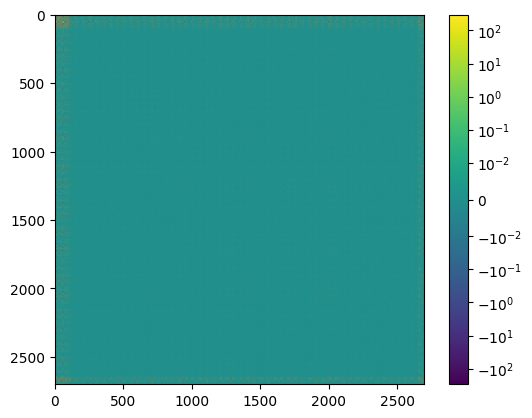

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

from laplax.util.flatten import flatten_function
from laplax.util.mv import to_dense
from laplax.util.tree import get_size

ggn_mv_wrapped = flatten_function(ggn_mv, layout=params)
arr = to_dense(ggn_mv_wrapped, layout=get_size(params))


plt.imshow(arr, norm=SymLogNorm(linthresh=1e-2, linscale=1))
plt.colorbar()
plt.show()

## Curvature estimators

In practice, we can not afford to dense and continue computations with the GGN. Therefore, various strategies for estimating the curvature exist. Within this package we have: `full` (obvious), `diagonal` and low_rank. For the latter, we support finding the low rank representation using `lanczos` or `lobpcg`. 

In [22]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown for library selection.
lib_dropdown = widgets.Dropdown(
    options=['full', 'diagonal', 'lanczos', 'lobpcg'],
    value='lanczos',
    description='Curv. est.:',
)
display(lib_dropdown)

ModuleNotFoundError: No module named 'ipywidgets'

In [ ]:
from laplax.curv import estimate_curvature

print(f"Curvature will be estimated using a {lib_dropdown.value} approximation.")
curv_type = lib_dropdown.value
low_rank_args = {
    "key": jax.random.key(20),
    "rank": 50,
    "mv_jittable": True,
}
curv_args = {} if curv_type in {"full", "diagonal"} else low_rank_args

curv_estimate = estimate_curvature(
    curv_type=curv_type,
    mv=ggn_mv,
    layout=params,
    **curv_args,
)
curv_estimate.U.shape

Curvature will be estimated using a lanczos approximation.


(193, 50)

## Create a posterior_fn

We can now create a `posterior_fn` that takes `prior_arguments` and returns a posterior distribution over the weights. This includes adding the prior precision $\tau$ and inverting the combined expression in a memory-efficient way:
$$ \text{posterior\_fn}(\tau) = \big( GGN + \tau I_{P\times P} \big)^{-1} $$
If we have already an estimation of the curvature, then we can directly set the posterior function using the estimate. Otherwise both functions can also be executed at once using the `laplax.curv.create_posterior_fn`. 

In [ ]:
from laplax.curv.cov import set_posterior_fn

posterior_fn = set_posterior_fn(curv_type, curv_estimate, layout=params)

# # Alternatively, we can create the posterior function from scratch, if no curvature
# # estimation is available.
# # Create Posterior
# posterior_fn = create_posterior_fn(
#     curv_type=curv_type,
#     mv=ggn_mv,
#     layout=params,
#     **curv_args,
# )
posterior_fn

<function laplax.curv.cov.set_posterior_fn.<locals>.posterior_fn(prior_arguments: collections.abc.Mapping[str, jax.Array | float], loss_scaling_factor: jaxtyping.Float = 1.0) -> jaxtyping.PyTree[jaxtyping.Num[Array, '...']]>

## How to pushforward the weight space uncertainty?

There are two ideas for pushing forward weight space uncertainty.

1. Sample-based pushforward via the neural network
$$ f(x_n, \theta_s), \quad \theta_s \sim \mathcal{N}\bigg(\theta_{MAP}, \Sigma\bigg)$$

2. Linearized pushforward
$$ f(x_n, \theta) \sim \mathcal{N}\bigg(f(x_n, \theta_{MAP}), \mathcal{J}_{\theta}(f(x_n, \theta_{\text{MAP}}))\Sigma \mathcal{J}_{\theta}(f(x_n, \theta_{\text{MAP}}))^\top\bigg)$$

**Recommendation:** Play around with the prior precision to see its strong modeling impact. Also check out larger intervals to see the uncertainty structure outside of the training domain.

### Sample-based pushforward via the neural network

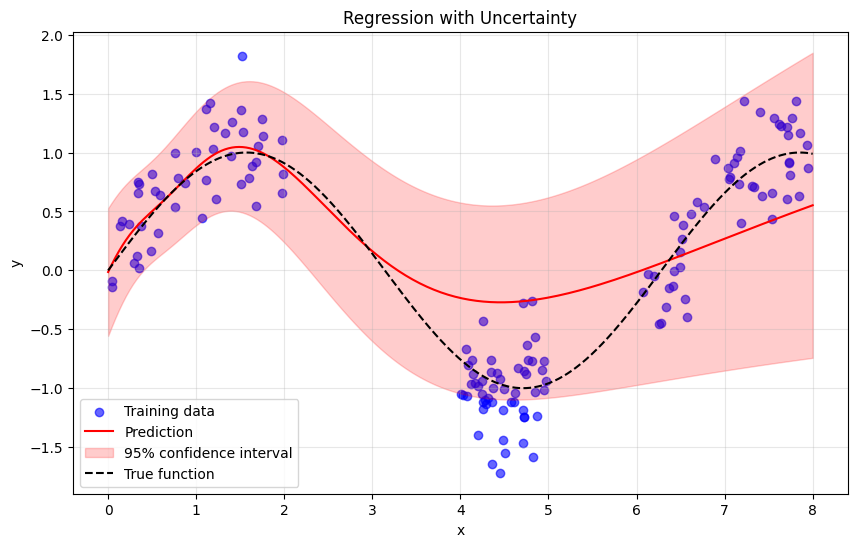

In [ ]:
from functools import partial

from plotting import plot_regression_with_uncertainty

from laplax.eval.pushforward import (
    nonlin_pred_mean,
    nonlin_pred_std,
    nonlin_pred_var,
    nonlin_setup,
    set_nonlin_pushforward,
)

# Setup linearized pushforward
set_nonlin_prob_predictive = partial(
    set_nonlin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        nonlin_setup,
        nonlin_pred_mean,
        nonlin_pred_var,
        nonlin_pred_std
    ],
    key=jax.random.key(42),
    num_samples=10000,
)
prior_arguments = {"prior_prec": 40.}  # Choose any prior precision.
prob_predictive = set_nonlin_prob_predictive(
    prior_arguments=prior_arguments,
)

X_pred = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred,
    y_pred=pred["pred_mean"][:, 0],
    y_std=jnp.sqrt(pred["pred_var"][:, 0]),
)

### Linearized pushforward

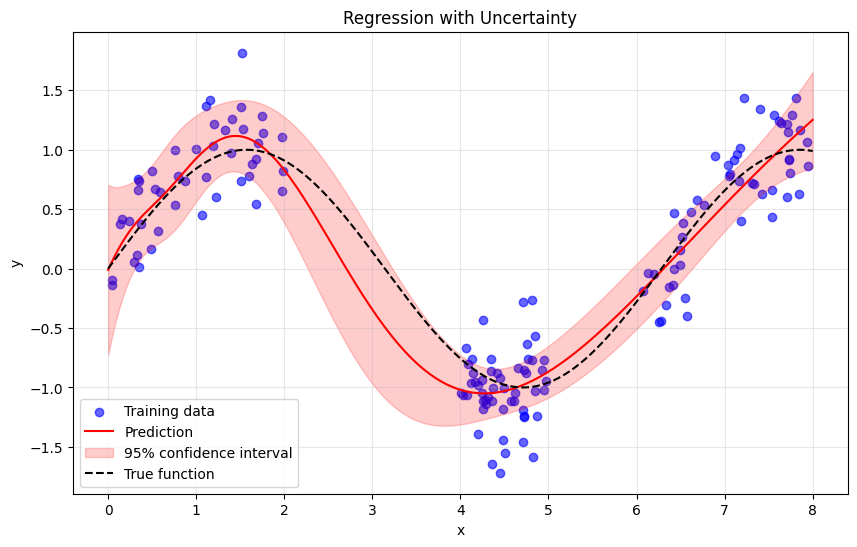

In [ ]:
from functools import partial

from plotting import plot_regression_with_uncertainty

from laplax.eval.pushforward import (
    lin_pred_mean,
    lin_pred_std,
    lin_pred_var,
    lin_setup,
    set_lin_pushforward,
)

# Setup linearized pushforward
set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_var,
        lin_pred_std,
    ],
)
prior_arguments = {"prior_prec": 1.}  # Choose any prior precision.
prob_predictive = set_prob_predictive(
    prior_arguments=prior_arguments,
)

X_pred = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred,
    y_pred=pred["pred_mean"][:, 0],
    y_std=jnp.sqrt(pred["pred_var"][:, 0])
)

## Calibration

When playing around we see that it is non-trivial of how to choose the prior precision. To do so with an heuristic we need to optimize some objective. There are two common strategies: either optimize for a downstream metric (e.g. Negative-Log Likelihood or average calibration ($\chi^2$)) or target the marginal log-likelihood. Later is a common objective for even more general model selection (see below) and is given by:

$$ \log p(\mathcal{D}\vert\mathcal{M}) = \log p(\mathcal{D} \vert \theta_{*}, \mathcal{M}) + \log p(\mathcal{\theta_*} \vert \mathcal{M}) - \frac{1}{2} \log \vert \frac{1}{2\pi} \mathrm{H}_{\theta_*}\vert $$

where $\mathrm{H}_{\theta_*}$ is the posterior precision and $\mathcal{M}$ other model parameters, such as the network architecture. We note that no inversion is needed compute the marginal log likelihood when updating the prior arguments. However, in practice optimizing for downstream metrics will also lead to better downstream metrics.

For optimization we can choose either grid search or gradient descent.

### Partially initializing `set_prob_predictive`


We always start by partially initializing the `set_prob_predictive`, such that it only misses the `prior_arguments`, which we will use for optimizing a chosen objective.

In [ ]:
from functools import partial

from laplax.eval.pushforward import (
    lin_pred_mean,
    lin_pred_std,
    lin_setup,
    set_lin_pushforward,
)

set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_std,
    ],
)

# Set a batch of calibration data
clbr_batch = {"input": X_valid, "target": y_valid}

### Select calibration objective

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown for library selection.
clbr_obj_dropdown = widgets.Dropdown(
    options=['nll', 'chi_squared', 'marginal log-likelihood'],
    value='nll',
    description='Objective:',
)
display(clbr_obj_dropdown)

Dropdown(description='Objective:', options=('nll', 'chi_squared', 'marginal log-likelihood'), value='nll')

In [ ]:
from laplax.eval import evaluate_for_given_prior_arguments, marginal_log_likelihood
from laplax.eval.metrics import chi_squared_zero, nll_gaussian


@jax.jit
def nll_objective(prior_arguments, batch):
    return evaluate_for_given_prior_arguments(
        prior_arguments=prior_arguments,
        data=batch,
        set_prob_predictive=set_prob_predictive,
        metric=nll_gaussian,
    )


@jax.jit
def chi_squared_objective(prior_arguments, batch):
    return evaluate_for_given_prior_arguments(
        prior_arguments=prior_arguments,
        data=batch,
        set_prob_predictive=set_prob_predictive,
        metric=chi_squared_zero
        # This is chi_squared tansformed to have its optimal value at zero.
    )


@jax.jit
def marginal_log_likelihood_objective(prior_arguments, batch):
    return - marginal_log_likelihood(
        curv_estimate,
        prior_arguments=prior_arguments,
        data=batch,
        model_fn=model_fn,
        params=params,
        loss_fn="mse",
        curv_type=curv_type,
    )


# Select objective based on dropdown menu
objective = {
    "nll": nll_objective,
    "chi_squared": chi_squared_objective,
    "marginal log-likelihood": marginal_log_likelihood_objective
}[clbr_obj_dropdown.value]

### Grid search

In [ ]:
from laplax.eval.calibrate import optimize_prior_prec

prior_prec = optimize_prior_prec(
    objective=partial(objective, batch=clbr_batch),
    log_prior_prec_min=-3.0,
    log_prior_prec_max=3.0,
    grid_size=50,
    # patience=5
)

print("Calibrated prior precision: ", prior_prec)

2025-05-11 17:05:31.186 | INFO     | laplax.eval.calibrate:grid_search:109 - Caught nan, setting result to inf.
2025-05-11 17:05:31.186 | INFO     | laplax.eval.calibrate:grid_search:113 - Took 0.1114 seconds, prior prec: 0.0010, result: inf
2025-05-11 17:05:31.187 | INFO     | laplax.eval.calibrate:grid_search:109 - Caught nan, setting result to inf.
2025-05-11 17:05:31.187 | INFO     | laplax.eval.calibrate:grid_search:113 - Took 0.0011 seconds, prior prec: 0.0013, result: inf
2025-05-11 17:05:31.189 | INFO     | laplax.eval.calibrate:grid_search:109 - Caught nan, setting result to inf.
2025-05-11 17:05:31.189 | INFO     | laplax.eval.calibrate:grid_search:113 - Took 0.0010 seconds, prior prec: 0.0018, result: inf
2025-05-11 17:05:31.190 | INFO     | laplax.eval.calibrate:grid_search:109 - Caught nan, setting result to inf.
2025-05-11 17:05:31.190 | INFO     | laplax.eval.calibrate:grid_search:113 - Took 0.0010 seconds, prior prec: 0.0023, result: inf
2025-05-11 17:05:31.191 | INFO  

Calibrated prior precision:  0.0040949145


We can use a similar pipeline to evaluate an arbitrary set of metrics. A few common regression metrics are natively supported in `laplax`.


Model Evaluation Metrics
----------------------------------------
chi^2 : 3.228246
crps  : 0.234069
nll   : 1.031892
rmse  : 0.325561


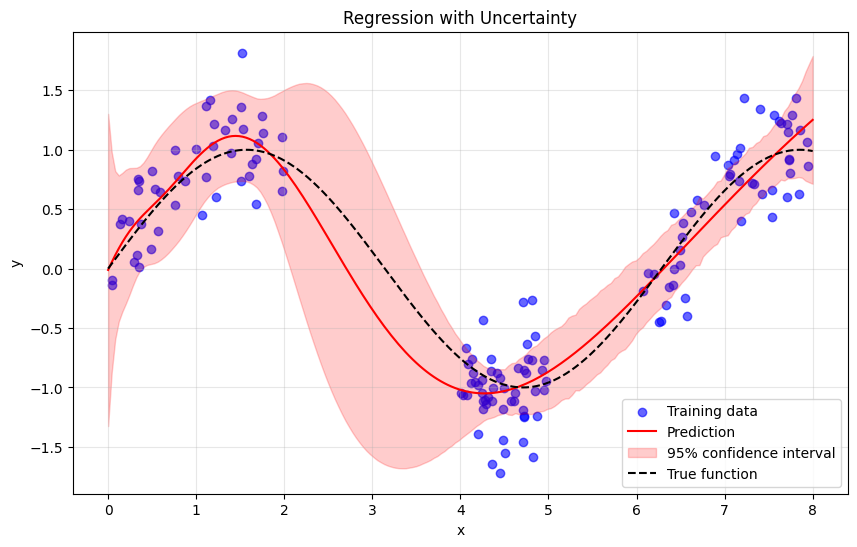

In [ ]:
from plotting import print_results

from laplax.eval.metrics import DEFAULT_REGRESSION_METRICS
from laplax.eval.utils import evaluate_metrics_on_dataset

# Set test batch
test_batch = {"input": X_test, "target": y_test}

prob_predictive = set_prob_predictive(prior_arguments={"prior_prec": prior_prec})
results = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,  # How to aggregate metrics over batch.
)


# Print metrics
print_results(results, "Model Evaluation Metrics")

# Predict for plot
X_pred = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred,
    y_pred=pred["pred_mean"][:, 0],
    y_std=jnp.sqrt(pred["pred_var"][:, 0])
)

### Gradient descent

A major benefit from the gradient descent objective is that we can straightforwardly extend the calibration to other hyperparameters. So far, we were just able to calibrate the prior precision, which will not account properly for the additional observation noise in our regression task. To change this, we will introduce the so-called `sigma` term in our objective, which will support us in modeling the model uncertainty as well. The marginal log-likelihood for the mean squared error loss is then given by:

$$ \log p(\mathcal{D}\vert\mathcal{M}) = \frac{1}{2\sigma}\sum_{n=1}^N (y_n - f(x_n, \theta_*))^2 + \tau \|\theta_*\|^2 - \frac{1}{2} \log \vert \frac{1}{2\pi} \mathrm{H}_{\theta_*}\vert $$

In [ ]:
# Initialize prior arguments
prior_arguments = {"prior_prec": jnp.array(1.0), "sigma": jnp.array(0.1)}

In [ ]:
from tqdm.auto import tqdm

# Set parameters
num_clbr_epochs = 20
lr = 1e-6

# Set optimizer
optimizer = optax.adam(lr)
opt_state = optimizer.init(prior_arguments)
valid_loader = DataLoader(X_valid, y_valid, batch_size=16)

# Transform prior arguments, so we can optimize over all reals
prior_arguments = jax.tree.map(jnp.log, prior_arguments)

# Optimize prior arguments
with tqdm(total=num_clbr_epochs, desc="Training") as pbar:
    for _ in range(num_clbr_epochs):
        epoch_vals = []
        for batch in valid_loader:
            val, grads = jax.value_and_grad(
                lambda p: objective(
                    jax.tree.map(jnp.exp, p), input_target_split(batch)  # noqa: B023
                )
            )(prior_arguments)

            # Update the parameters using the optimizer
            updates, opt_state = optimizer.update(grads, opt_state)
            prior_arguments = optax.apply_updates(prior_arguments, updates)
            epoch_vals.append(val)

        avg_val = sum(epoch_vals) / len(epoch_vals)
        pbar.set_postfix({'objective': f'{avg_val:.4f}'})
        pbar.update(1)

# Transform prior arguments back
prior_arguments = jax.tree.map(jnp.exp, prior_arguments)

print("Final values:", dict(prior_arguments))

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Final values: {'prior_prec': Array(1.0000714, dtype=float32), 'sigma': Array(0.10000672, dtype=float32)}



Model Evaluation Metrics
----------------------------------------
chi^2 : 0.881090
crps  : 0.224710
nll   : 0.492159
rmse  : 0.325561


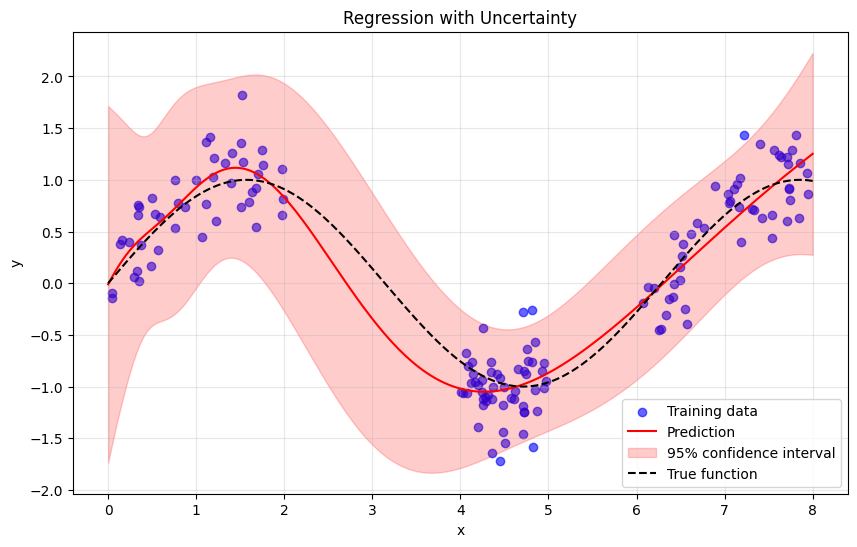

In [ ]:
from laplax.eval.metrics import DEFAULT_REGRESSION_METRICS
from laplax.eval.utils import evaluate_metrics_on_dataset

prob_predictive = set_prob_predictive(prior_arguments=prior_arguments)
results = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,  # How to aggregate metrics over batch.
)

# Print metrics
print_results(results, "Model Evaluation Metrics")

# Predict for plot
X_pred = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred,
    y_pred=pred["pred_mean"][:, 0],
    y_std=jnp.sqrt(pred["pred_var"][:, 0])
)

## Bonus: Registering `skerch`

Let us get to some bonus content. One benefit of `laplax` is its modularity, which should make it easy to extend or bend its use cases. For example, we can easily register our favorite curvature approximation method: `skerch`; even though it was written for `torch`. To make it available for creating a posterior function based on its curvature structure, we can either implement (+register) all methods or refer to a default method, which might already exist in `laplax`.

In [ ]:
import numpy as np
import torch
from skerch import linops
from skerch.decompositions import seigh

from laplax.curv.utils import LowRankTerms, get_matvec
from laplax.register import register_curvature_method
from laplax.types import DType


class JAXMV(linops.TorchLinOpWrapper):
    def __init__(self, matvec, shape):
        self.shape = shape
        self.matvec = matvec

    def __matmul__(self, x):
        x_dtype = x.dtype
        x = jnp.asarray(x.detach().cpu().numpy())
        x = self.matvec(x)
        return torch.tensor(np.asarray(x), dtype=x_dtype)

    def __rmatmul__(self, x):
        return self.__matmul__(x.T)


def skerch_low_rank(
    A,
    *,
    layout=None,
    rank: int = 100,
    return_dtype: DType = jnp.float64,
    mv_jittable=True,
    **kwargs,
):
    del kwargs
    # Setup mv product.
    matvec, size = get_matvec(A, layout=layout, jit=mv_jittable)
    op = JAXMV(matvec, (size, size))

    res = seigh(
        op, op_device="cpu", op_dtype=torch.float64, outer_dim=rank, inner_dim=rank
    )

    low_rank_result = LowRankTerms(
        U=jnp.asarray((res[0] @ res[1]).detach().cpu()),
        S=jnp.asarray(res[2].detach().cpu().numpy()),
        scalar=jnp.asarray(0.0, dtype=return_dtype),
    )
    return low_rank_result



register_curvature_method(
    name="skerch", create_curvature_fn=skerch_low_rank, default="lanczos"
)

In [ ]:
from laplax.curv import create_posterior_fn

posterior_fn = create_posterior_fn(
    curv_type="skerch",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
    rank=50,
    mv_jittable=True,
)

/var/folders/kd/3t0zj8gs1zz4f2qpq9dpm0xw0000gn/T/ipykernel_41741/673500682.py:47: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  scalar=jnp.asarray(0.0, dtype=return_dtype),


## Bonus: Posterior GP kernel

We can now use the posterior function to create a Laplace (GP) kernel to also model covariances between various inputs. While the default only takes a single input, we can use standard vectorization techniques to apply it to multiple inputs at the same time.

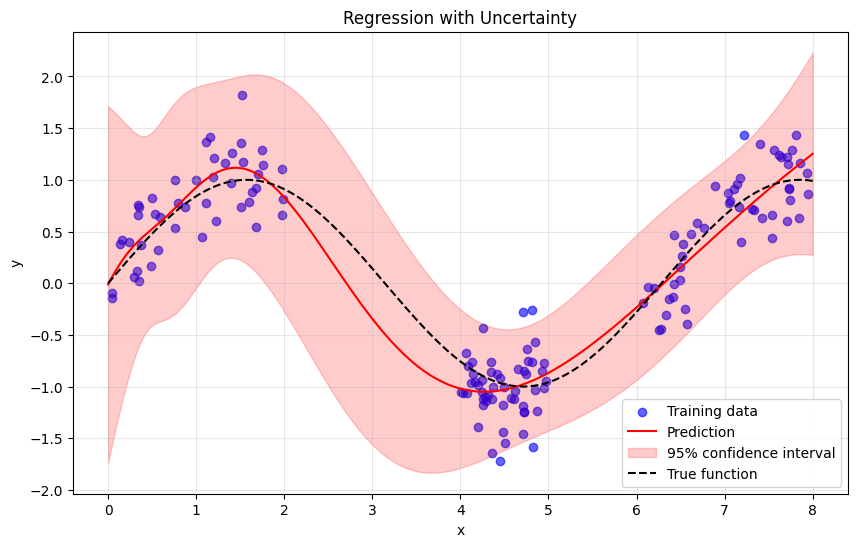

In [ ]:
from laplax.eval.pushforward import set_posterior_gp_kernel

gp_kernel, dist_state = set_posterior_gp_kernel(
    model_fn=model_fn,
    mean=params,
    posterior_fn=posterior_fn,
    prior_arguments=prior_arguments,
    dense=True,  # If dense = False, then a slower kernel-vector product is returned.
    output_layout=1,
)


def vectorized_laplace_kernel(a, b):
    return jnp.vectorize(gp_kernel, signature="(d),(d)->(j,j)")(a, b)[..., 0]


X_pred = jnp.linspace(0., 8., 200).reshape(200, 1)
Y_pred = model_fn(X_pred, params)[:, 0]
Y_var = vectorized_laplace_kernel(X_pred, X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred[:, 0],
    y_pred=Y_pred,
    y_std=jnp.sqrt(Y_var)[:, 0],
)

OK, in this little example this is not so much of an advantage. However, for more complex models/datasets this can be a huge support for downstream tasks.

## Bonus: Model selection

In [ ]:
class ModelOverfit(nnx.Module):
    def __init__(self, rngs):
        self.linear1 = nnx.Linear(1, 25, rngs=rngs)
        self.linear2 = nnx.Linear(25, 50, rngs=rngs)
        self.linear3 = nnx.Linear(50, 25, rngs=rngs)
        self.linear4 = nnx.Linear(25, 1, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = nnx.tanh(self.linear2(x))
        x = nnx.tanh(self.linear3(x))
        x = nnx.tanh(self.linear4(x))
        return x


class FullOverfit(nnx.Module):
    def __init__(self, rngs):
        self.linear1 = nnx.Linear(1, 25, rngs=rngs)
        self.linear2 = nnx.Linear(25, 50, rngs=rngs)
        self.linear3 = nnx.Linear(50, 25, rngs=rngs)
        self.linear4 = nnx.Linear(25, 50, rngs=rngs)
        self.linear5 = nnx.Linear(50, 25, rngs=rngs)
        self.linear6 = nnx.Linear(25, 50, rngs=rngs)
        self.linear7 = nnx.Linear(50, 25, rngs=rngs)
        self.linear8 = nnx.Linear(25, 1, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = nnx.tanh(self.linear2(x))
        x = nnx.tanh(self.linear3(x))
        x = nnx.tanh(self.linear4(x))
        x = nnx.tanh(self.linear5(x))
        x = nnx.tanh(self.linear6(x))
        x = nnx.tanh(self.linear7(x))
        x = nnx.tanh(self.linear8(x))
        return x


n_epochs = 1000
lr = 1e-3
rngs = nnx.Rngs(0)
models = [
    (Model(1, 2, 1, rngs=rngs), 1000, 1e-3, "1-2-1"),
    (Model(1, 50, 1, rngs=rngs), 1000, 1e-3, "1-50-1"),
    (Model(1, 600, 1, rngs=rngs), 1000, 1e-3, "1-600-1"),
    (ModelOverfit(rngs=rngs), n_epochs, 1e-3, "1-25-50-25-1"),
    (FullOverfit(rngs=rngs), n_epochs, 1e-3, "1-25-50-25-50-25-50-25-1"),
]

trained_models = []
for model, num_epoch, lr, name in models:
    print(f"Model {name}")
    model.name = name
    trained_models.append(train_model(model, num_epoch, lr))
    print("-" * 40)

Model 1-2-1
[epoch 0]: loss: 5.9635
[epoch 100]: loss: 6.2015
[epoch 200]: loss: 8.1277
[epoch 300]: loss: 5.1091
[epoch 400]: loss: 8.0070
[epoch 500]: loss: 7.9144
[epoch 600]: loss: 5.4761
[epoch 700]: loss: 7.9413
[epoch 800]: loss: 7.0130
[epoch 900]: loss: 3.6976
Final loss: 6.2531
----------------------------------------
Model 1-50-1
[epoch 0]: loss: 9.9370
[epoch 100]: loss: 5.0796
[epoch 200]: loss: 1.5793
[epoch 300]: loss: 0.9821
[epoch 400]: loss: 2.2806
[epoch 500]: loss: 0.5455
[epoch 600]: loss: 0.8418
[epoch 700]: loss: 0.9990
[epoch 800]: loss: 0.5869
[epoch 900]: loss: 0.7341
Final loss: 0.8031
----------------------------------------
Model 1-600-1
[epoch 0]: loss: 7.7758
[epoch 100]: loss: 1.7799
[epoch 200]: loss: 0.8167
[epoch 300]: loss: 2.1499
[epoch 400]: loss: 0.6092
[epoch 500]: loss: 0.6395
[epoch 600]: loss: 0.9502
[epoch 700]: loss: 1.2497
[epoch 800]: loss: 1.5076
[epoch 900]: loss: 0.6278
Final loss: 0.4323
----------------------------------------
Model 1

In [ ]:
marglik = {}
train_batch = {"input": X_train, "target": y_train}
prior_arguments = {"prior_prec": 1.0}
curv_type = "lanczos"

for model in trained_models:
    # Prepare model
    graph_def, params = nnx.split(model)
    def model_fn(input, params):
        return nnx.call((graph_def, params))(input)[0]  # noqa: B023

    curv_approx = estimate_curvature(
        curv_type=curv_type,
        mv=create_ggn_mv(
            model_fn,
            params,
            train_batch,
            loss_fn="mse"
        ),
        layout=params,
        key=jax.random.key(0),  # If necessary
        rank=50,  # If necessary
    )

    marglik[model.name] = marginal_log_likelihood(
        curv_estimate=curv_approx,
        prior_arguments=prior_arguments,
        data=train_batch,
        model_fn=model_fn,
        params=params,
        loss_fn="mse",
        curv_type=curv_type
    ).item()

In [ ]:
print_results(marglik, "Marginal log-likelihood")


Marginal log-likelihood
----------------------------------------
1-2-1                    : -61.156006
1-50-1                   : -60.314133
1-600-1                  : -225.644897
1-25-50-25-1             : -89.081299
1-25-50-25-50-25-50-25-1 : -192.647461


We would choose the model with the highest marginal log-likelihood. If there exist additional (continuous/relaxed) model parameters, we could use again the marginal log-likelihood in a gradient-based optimization to find its *optimal* values. Such procedures are often discussed under the name of model selection and differentiable Laplace.

In [ ]:
import jax
import jax.numpy as jnp
import gpjax as gpx

In [ ]:
x = jnp.linspace(-2, 2, 20).reshape(-1, 1)
kernel1 = gpx.kernels.Periodic(lengthscale=1.0)
kernel2 = gpx.kernels.Periodic(lengthscale=0.5, period=5)

def kernel_fn(kernel, x, y):
    return gpx.kernels.computations.DenseKernelComputation().cross_covariance(kernel, x, y) + 1e-4 * jnp.eye(x.shape[0])


In [ ]:
K1 = kernel_fn(kernel1, x, x)
K2 = kernel_fn(kernel2, x, x)
jnp.linalg.eigvalsh(K1)

Array([9.95108858e-05, 9.97110983e-05, 9.99114636e-05, 1.00036290e-04,
       1.00124598e-04, 1.00201491e-04, 1.00304584e-04, 1.00314552e-04,
       1.00813304e-04, 1.03660626e-04, 1.04176965e-04, 2.50851823e-04,
       2.62677902e-04, 4.93567623e-03, 5.33796661e-03, 1.16306640e-01,
       1.26835793e-01, 1.86423993e+00, 2.05034757e+00, 1.58323765e+01],      dtype=float32)